In [33]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import torch
import torch.nn as nn
import yaml
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm

sys.path.append("../input/modules")
from utils import read_hdf5
from models import Cnn14_DecisionLevelAtt
sys.path.append("../input/iterative-stratification-master")
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train_tp = pd.read_csv('../input/rfcx-species-audio-detection/train_tp.csv')
train_fp = pd.read_csv('../input/rfcx-species-audio-detection/train_fp.csv')
tmp = pd.DataFrame(train_tp["recording_id"].value_counts()).reset_index().rename(columns={'index': 'recording_id', "recording_id": "count"})
train_tp["t_diff"] = train_tp["t_max"] - train_tp["t_min"]
train_tp["f_diff"] = train_tp["f_max"] - train_tp["f_min"]
train_fp["t_diff"] = train_fp["t_max"] - train_fp["t_min"]
train_fp["f_diff"] = train_fp["f_max"] - train_fp["f_min"]
train_tp = pd.merge(train_tp, tmp, on="recording_id", how='inner')
train_tp["count"].value_counts()

1    1065
2     110
3      24
4      12
5       5
Name: count, dtype: int64

In [3]:
tmp = pd.DataFrame(train_fp["recording_id"].value_counts()).reset_index().rename(columns={'index': 'recording_id', "recording_id": "count"})
train_fp = pd.merge(train_fp, tmp, on="recording_id", how='inner')
train_fp["count"].value_counts()

1     2028
2     1716
3     1635
4     1356
5      575
6      294
7      126
8       32
10      10
9        9
Name: count, dtype: int64

In [7]:
train_path_list = os.listdir("../input/rfcx-species-audio-detection/train")
test_path_list = os.listdir("../input/rfcx-species-audio-detection/test")
print(f"train:{len(train_path_list)}, test:{len(test_path_list)}")
# print("train")
# for path in tqdm(train_path_list):
#     path = os.path.join("../input/rfcx-species-audio-detection/train", path)
#     y, sr = librosa.load(path=path, sr=None)
#     if (sr != 48000) or (len(y) != 2880000):
#         print(path, y.shape, sr)
# print("test")
# for path in tqdm(test_path_list):
#     path = os.path.join("../input/rfcx-species-audio-detection/test", path)
#     y, sr = librosa.load(path=path, sr=None)
#     if (sr != 48000) or (len(y) != 2880000):
#         print(path, y.shape, sr)

train:4727, test:1992


In [8]:
tp_list = train_tp["recording_id"].unique() + ".flac"
train_tp_list = []
for path in train_path_list:
    if path in tp_list:
        train_tp_list.append(os.path.join("../input/rfcx-species-audio-detection/train", path))

In [9]:
def logmelfilterbank(
    audio,
    sampling_rate,
    fft_size=1024,
    hop_size=256,
    win_length=None,
    window="hann",
    num_mels=80,
    fmin=None,
    fmax=None,
    eps=1e-10,
):
    """Compute log-Mel filterbank feature.

    Args:
        audio (ndarray): Audio signal (T,).
        sampling_rate (int): Sampling rate.
        fft_size (int): FFT size.
        hop_size (int): Hop size.
        win_length (int): Window length. If set to None, it will be the same as fft_size.
        window (str): Window function type.
        num_mels (int): Number of mel basis.
        fmin (int): Minimum frequency in mel basis calculation.
        fmax (int): Maximum frequency in mel basis calculation.
        eps (float): Epsilon value to avoid inf in log calculation.

    Returns:
        ndarray: Log Mel filterbank feature (#frames, num_mels).

    """
    # get amplitude spectrogram
    x_stft = librosa.stft(
        audio,
        n_fft=fft_size,
        hop_length=hop_size,
        win_length=win_length,
        window=window,
        pad_mode="reflect",
    )
    spc = np.abs(x_stft).T  # (#frames, #bins)

    # get mel basis
    fmin = 0 if fmin is None else fmin
    fmax = sampling_rate / 2 if fmax is None else fmax
    mel_basis = librosa.filters.mel(sampling_rate, fft_size, num_mels, fmin, fmax)

    return np.log10(np.maximum(eps, np.dot(spc, mel_basis.T)))


In [10]:
y, sr = librosa.load(path=train_tp_list[10], sr=32000)
# y = (y -y.mean()) / y.std()
logmel = logmelfilterbank(
    y,
    sr,
    fft_size=2048,
    hop_size=512,
    win_length=None,
    window="hann",
    num_mels=128,
    fmin=50,
    fmax=16000,
    eps=1e-10,
)

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(y)
plt.subplot(2, 2, 2)
plt.imshow(logmel.T, aspect="auto")

plt.colorbar()
y, sr = librosa.load(path=train_tp_list[10], sr=48000)
# y = (y -y.mean()) / y.std()
logmel = logmelfilterbank(
    y,
    sr,
    fft_size=2048,
    hop_size=512,
    win_length=None,
    window="hann",
    num_mels=128,
    fmin=50,
    fmax=16000,
    eps=1e-10,
)
plt.subplot(2, 2, 3)
plt.plot(y)
plt.subplot(2, 2, 4)
plt.imshow(logmel.T, aspect="auto")
plt.colorbar()

# plt.savefig("spec.png")

In [ ]:
(logmel.mean(axis=0) > -3).sum()

In [ ]:
logmel.shape

In [ ]:
train_tp_list[10].split("/")[-1][:-5]

In [ ]:
train_tp.sort_values('f_max')

In [ ]:
train_tp

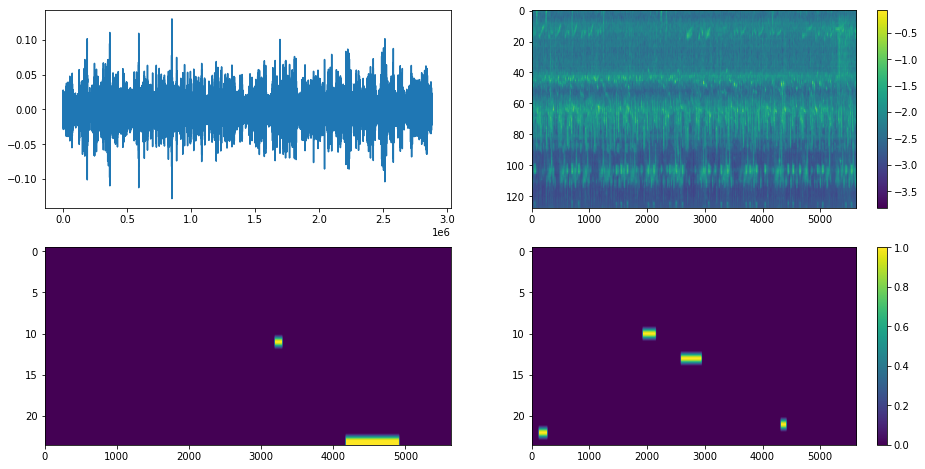

In [35]:
path = "dump/wave/train/551385b05.h5" # "dump/wave/train/c12e0a62b.h5"
wave = read_hdf5(hdf5_name=path, hdf5_path="wave")
mel = read_hdf5(hdf5_name=path, hdf5_path="feats")
matrix_tp = read_hdf5(hdf5_name=path, hdf5_path="matrix_tp")
matrix_fp = read_hdf5(hdf5_name=path, hdf5_path="matrix_fp")

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(wave)
plt.subplot(2, 2, 2)
plt.imshow(mel.T, aspect="auto")
plt.colorbar()
plt.subplot(2, 2, 3)
plt.imshow(matrix_tp.T, aspect="auto")
plt.subplot(2, 2, 4)
plt.imshow(matrix_fp.T, aspect="auto")
plt.colorbar()

In [25]:
mel.shape

(5626, 128)

In [26]:
train_tp.sort_values("t_diff")

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,t_diff,f_diff,count
960,c9fc89429,14,1,39.3493,3750.00,39.6213,6468.75,0.2720,2718.75,1
30,055088446,14,1,58.9920,3750.00,59.2640,6468.75,0.2720,2718.75,1
628,7ed4d3ca1,14,1,17.9520,3750.00,18.2240,6468.75,0.2720,2718.75,1
844,b1c09c89b,14,1,30.9493,3750.00,31.2213,6468.75,0.2720,2718.75,1
1124,e97de3f6d,14,1,56.6933,3750.00,56.9653,6468.75,0.2720,2718.75,1
...,...,...,...,...,...,...,...,...,...,...
402,551385b05,23,4,44.4372,6459.96,52.3610,11627.90,7.9238,5167.94,2
481,604583528,23,4,51.9314,6459.96,59.8552,11627.90,7.9238,5167.94,1
587,774912d66,23,4,29.7215,6459.96,37.6454,11627.90,7.9239,5167.94,2
107,16553d5cd,23,4,41.7088,6459.96,49.6327,11627.90,7.9239,5167.94,2


In [40]:
model = Cnn14_DecisionLevelAtt(sample_rate=16000,
        window_size=1024,
        hop_size=256,
        mel_bins=64,
        fmin=50,
        fmax=8000,
        classes_num=24,
        training=False,
        require_prep=True,
        is_spec_augmenter=False,
        mixup_lambda=None,)
for param in model.state_dict().keys():
    print(param)
# x = torch.tensor(wave[:288000]).unsqueeze(0)
# y = model(x)

spectrogram_extractor.stft.conv_real.weight
spectrogram_extractor.stft.conv_imag.weight
logmel_extractor.melW
bn0.weight
bn0.bias
bn0.running_mean
bn0.running_var
bn0.num_batches_tracked
conv_block1.conv1.weight
conv_block1.conv2.weight
conv_block1.bn1.weight
conv_block1.bn1.bias
conv_block1.bn1.running_mean
conv_block1.bn1.running_var
conv_block1.bn1.num_batches_tracked
conv_block1.bn2.weight
conv_block1.bn2.bias
conv_block1.bn2.running_mean
conv_block1.bn2.running_var
conv_block1.bn2.num_batches_tracked
conv_block2.conv1.weight
conv_block2.conv2.weight
conv_block2.bn1.weight
conv_block2.bn1.bias
conv_block2.bn1.running_mean
conv_block2.bn1.running_var
conv_block2.bn1.num_batches_tracked
conv_block2.bn2.weight
conv_block2.bn2.bias
conv_block2.bn2.running_mean
conv_block2.bn2.running_var
conv_block2.bn2.num_batches_tracked
conv_block3.conv1.weight
conv_block3.conv2.weight
conv_block3.bn1.weight
conv_block3.bn1.bias
conv_block3.bn1.running_mean
conv_block3.bn1.running_var
conv_block3.bn

In [41]:
nn.init.xavier_uniform_(model.att_block.weight)

AttributeError: 'AttBlock' object has no attribute 'weight'

In [6]:
tp_list = train_tp["recording_id"].unique()
fp_list = train_fp["recording_id"].unique()

In [8]:
time_list = train_tp[train_tp["recording_id"]=="c12e0a62b"].loc[:, ["species_id", "t_min", "t_max"]].values

In [9]:
time_list

array([[ 9.    , 14.9653, 17.7707],
       [17.    ,  1.5467,  8.    ],
       [17.    , 11.92  , 18.3733],
       [ 3.    , 21.568 , 22.3093],
       [17.    , 23.488 , 29.9413]])

In [29]:
matrix_tp.any(axis=0).astype(np.int64)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1])

In [34]:
from losses import FrameClipLoss

In [4]:
submission = pd.read_csv('../input/rfcx-species-audio-detection/sample_submission.csv')

In [7]:
columns = ["recording_id"] + [f"s{i}" for i in range(24)]
ground_truth = pd.DataFrame(np.zeros((len(tp_list), 25)), columns=columns)
ground_truth["recording_id"] = train_tp["recording_id"].unique()
for i, recording_id in enumerate(train_tp["recording_id"].values):
    ground_truth.iloc[ground_truth["recording_id"]==recording_id, train_tp.loc[i, "species_id"]+1] = 1.0

In [19]:
kfold = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=1)
y = ground_truth.iloc[:, 1:].values
for i, (train_idx, valid_idx) in enumerate(kfold.split(y, y)):
    train_y = ground_truth.iloc[train_idx]
    valid_y = ground_truth.iloc[valid_idx]
    if i == 0:
        break

In [30]:
train_tp["use_train"] = train_tp["recording_id"].map(lambda x: x not in valid_y["recording_id"].values)
train_tp[~train_tp["use_train"]]

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,t_diff,f_diff,count,use_train
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70,2.4439,9905.239,1,False
21,03d77fede,0,1,44.4107,5906.250,45.2053,8250.00,0.7946,2343.750,1,False
26,0509303a5,6,1,23.7013,562.500,25.8453,4406.25,2.1440,3843.750,1,False
36,068f1b8e2,12,1,22.8640,562.500,26.0000,3281.25,3.1360,2718.750,1,False
39,073e4d908,12,1,12.4960,562.500,15.6320,3281.25,3.1360,2718.750,1,False
...,...,...,...,...,...,...,...,...,...,...,...
1196,fb02b0607,21,1,36.4427,3281.250,37.5360,4125.00,1.0933,843.750,1,False
1201,fbd5bbb6e,23,4,45.0990,6459.960,53.0228,11627.90,7.9238,5167.940,1,False
1203,fc6609050,0,1,42.9973,5906.250,43.7920,8250.00,0.7947,2343.750,1,False
1204,fc6c3b488,21,1,42.3467,3281.250,43.4400,4125.00,1.0933,843.750,1,False


In [28]:
train_tp["use_train"].sum()

976

In [21]:
print(train_y.shape, valid_y.shape)
print(train_y.sum(axis=0)//4)
print(valid_y.sum(axis=0))

(905, 25) (227, 25)


TypeError: unsupported operand type(s) for //: 'str' and 'int'

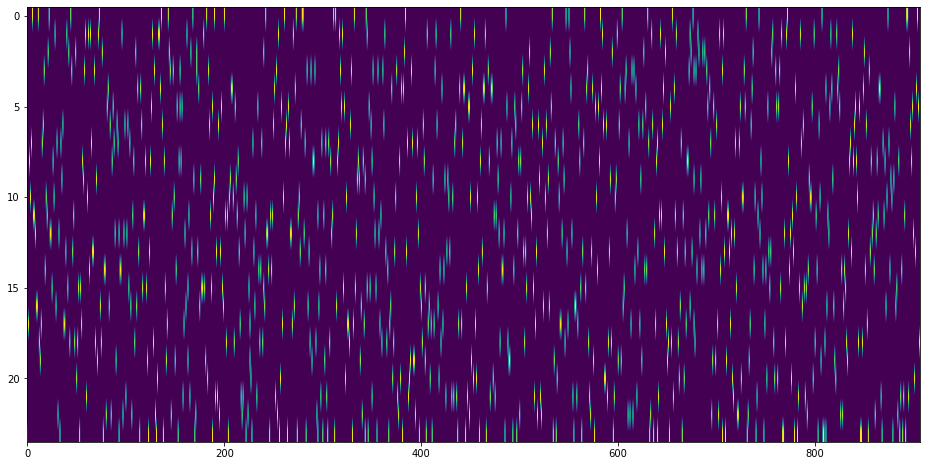

In [11]:
plt.figure(figsize=(16, 8))
plt.imshow(train_y.T, aspect="auto")

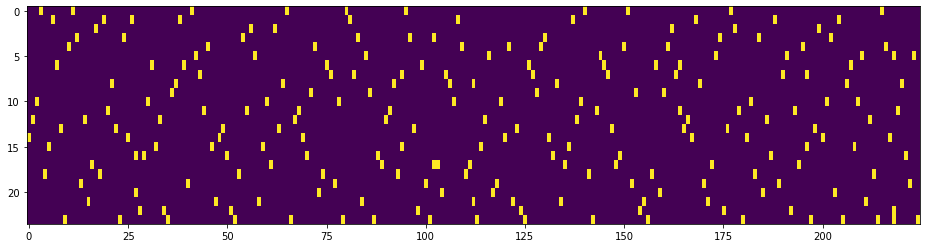

In [12]:
plt.figure(figsize=(16, 4))
plt.imshow(valid_y.T, aspect="auto")

In [13]:
submission

,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,000316da7,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,003bc2cb2,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,0061c037e,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
3,010eb14d3,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
4,011318064,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,ff68f3ac3,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1988,ff973e852,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1989,ffa5cf6d6,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1990,ffa88cbb8,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
